# Overview

Impute all your features.

In [1]:
import datetime
import os
import textwrap

import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from bokeh.io import output_notebook
from bokeh.models import DatetimeTickFormatter, HoverTool
from bokeh.plotting import figure, show
from hyperopt.pyll.base import scope
from pyspark.sql import SparkSession
from scipy.stats import chi2_contingency
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import RFE, RFECV, SelectKBest, chi2
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from JapanHorseRaceAnalytics.utilities.base import get_base_dir, read_hive_table
from JapanHorseRaceAnalytics.utilities.structured_logger import logger

# Set pandas display options
pd.set_option("display.max_rows", 1050)
pd.set_option("display.max_columns", 200)

# Set seed for reproducibility
os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)
random_state = 42


output_notebook()


def chi2_test(df, col1, col2):
    contingency_table = pd.crosstab(df[col1], df[col2], dropna=False)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"chi2: {chi2}, p: {p}, dof: {dof}")

    categories = contingency_table.index
    fig, ax = plt.subplots(figsize=(6, 4))

    ind = np.arange(len(categories))
    width = 0.35

    ax.bar(
        ind - width / 2,
        contingency_table.values[:, 0],
        width,
        label="Observed Yes",
        color="skyblue",
    )
    ax.bar(ind + width / 2, expected[:, 0], width, label="Expected Yes", color="orange")

    description = """
    "Observed Yes" represents the actual counts of the event happening for each category,
    while the "Expected Yes" bars show the counts we would expect if there was no association
    between the two variables. The size of the "Observed Yes" bars relative to the "Expected
    Yes" bars indicates the strength of the association.
    """
    # wrap the text to 70 characters and then print out the indented text
    description = textwrap.fill(textwrap.dedent(description.strip()), width=70)
    print(description)

    ax.set_xlabel("Categories")
    ax.set_ylabel("Counts")
    ax.set_title("Observed vs Expected Counts")
    ax.set_xticks(ind)
    ax.set_xticklabels(categories)
    ax.legend()

    plt.tight_layout()
    plt.show()

Loading BokehJS ...

In [2]:
warehouse_dir = f"{get_base_dir()}/spark-warehouse"
postgres_driver_path = f"{get_base_dir()}/jars/postgresql-42.7.1.jar"

spark = (
    SparkSession.builder.appName("20240211_competitors")
    .config("spark.driver.memory", "20g")
    .config("spark.sql.warehouse.dir", warehouse_dir)
    .config("spark.jars", postgres_driver_path)
    .config("spark.executor.extraClassPath", postgres_driver_path)
    .config("spark.driver.extraClassPath", postgres_driver_path)
    .enableHiveSupport()
    .getOrCreate()
)

24/03/01 06:47:18 WARN Utils: Your hostname, Hanks-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.40.105 instead (on interface en0)
24/03/01 06:47:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/03/01 06:47:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [27]:
# Something strange is happening when you load dates from parquet?? The race time should be 11:00 for this race.
# Everything is OK in the database.
df[df["meta_レースキー"] == '06131503']["meta_発走日時"]

5141     2013-01-14 02:00:00
15854    2013-01-14 02:00:00
133447   2013-01-14 02:00:00
218496   2013-01-14 02:00:00
218497   2013-01-14 02:00:00
260953   2013-01-14 02:00:00
377660   2013-01-14 02:00:00
409456   2013-01-14 02:00:00
494355   2013-01-14 02:00:00
526170   2013-01-14 02:00:00
695325   2013-01-14 02:00:00
726940   2013-01-14 02:00:00
737496   2013-01-14 02:00:00
769082   2013-01-14 02:00:00
Name: meta_発走日時, dtype: datetime64[ns]

In [2]:
data = read_hive_table(
    table_name="features_20240217_v1",
    schema="jhra_curated",
    spark_session=None,
    # use_cache=False,
)

# drop from data where cat_トラック種別 == "障害"
data = data[(data["cat_トラック種別"] != "障害")]

# drop from data where meta_int_race_horses_異常区分 != '0'
data = data[(data["meta_int_race_horses_異常区分"] == "0")]

data = data.reset_index(drop=True)
data.head()

{"event": "Read from parquet /Users/hankehly/Projects/JapanHorseRaceAnalytics/data/sql_tables/features_20240217_v1.snappy.parquet to pandas", "level": "info", "timestamp": "2024-02-29T21:52:42.751291Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}


,meta_レースキー,meta_馬番,meta_着順,meta_本賞金,meta_単勝的中,meta_単勝払戻金,meta_複勝的中,meta_複勝払戻金,meta_int_races_レースキー,meta_発走日時,meta_場コード,cat_四半期,cat_距離,cat_事前_馬場状態コード,num_事前_馬場差,cat_実績_馬場状態コード,num_実績_馬場差,cat_レース条件_記号,cat_レース条件_条件,cat_レース条件_重量,cat_レース条件_トラック情報_内外,cat_レース条件_トラック情報_右左,cat_レース条件_種別,cat_レース条件_グレード,num_頭数,cat_トラック種別,cat_馬場状態内,cat_馬場状態中,cat_馬場状態外,num_直線馬場差最内,num_直線馬場差内,num_直線馬場差中,num_直線馬場差外,num_直線馬場差大外,cat_芝種類,num_草丈,cat_転圧,cat_凍結防止剤,num_中間降水量,meta_int_race_horses_レースキー,meta_int_race_horses_馬番,meta_int_race_horses_血統登録番号,meta_int_race_horses_発走日時,meta_int_race_horses_異常区分,num_事前ＩＤＭ,cat_事前脚質,num_事前単勝オッズ,num_事前複勝オッズ,cat_事前馬体,cat_事前気配コード,cat_事前上昇度,cat_事前クラスコード,num_事前テン指数,num_事前ペース指数,num_事前上がり指数,num_負担重量,num_馬体重,num_馬体重増減,cat_性別,cat_トラック種別瞬発戦好走馬,cat_トラック種別消耗戦好走馬,num_一走前不利,num_二走前不利,num_三走前不利,num_一走前着順,num_二走前着順,num_三走前着順,num_四走前着順,num_五走前着順,num_六走前着順,num_1走前上昇度,num_2走前上昇度,num_3走前上昇度,num_4走前上昇度,num_5走前上昇度,num_騎手指数,num_情報指数,num_オッズ指数,num_パドック指数,num_総合指数,cat_馬具変更情報,cat_脚元情報,cat_見習い区分,cat_オッズ印,cat_パドック印,cat_直前総合印,cat_距離適性,num_ローテーション,num_基準オッズ,num_基準人気順位,num_基準複勝オッズ,num_基準複勝人気順位,num_特定情報◎,num_特定情報○,num_特定情報▲,num_特定情報△,num_特定情報×,num_総合情報◎,num_総合情報○,num_総合情報▲,...,num_競争相手平均調教師1位完走,num_競争相手調教師1位完走標準偏差,num_競争相手最高調教師トップ3完走,num_競争相手最低調教師トップ3完走,num_競争相手平均調教師トップ3完走,num_競争相手調教師トップ3完走標準偏差,num_競争相手最高調教師1位完走率,num_競争相手最低調教師1位完走率,num_競争相手平均調教師1位完走率,num_競争相手調教師1位完走率標準偏差,num_競争相手最高調教師トップ3完走率,num_競争相手最低調教師トップ3完走率,num_競争相手平均調教師トップ3完走率,num_競争相手調教師トップ3完走率標準偏差,num_競争相手最高調教師場所レース数,num_競争相手最低調教師場所レース数,num_競争相手平均調教師場所レース数,num_競争相手調教師場所レース数標準偏差,num_競争相手最高調教師場所1位完走,num_競争相手最低調教師場所1位完走,num_競争相手平均調教師場所1位完走,num_競争相手調教師場所1位完走標準偏差,num_競争相手最高調教師場所トップ3完走,num_競争相手最低調教師場所トップ3完走,num_競争相手平均調教師場所トップ3完走,num_競争相手調教師場所トップ3完走標準偏差,num_競争相手最高調教師場所1位完走率,num_競争相手最低調教師場所1位完走率,num_競争相手平均調教師場所1位完走率,num_競争相手調教師場所1位完走率標準偏差,num_競争相手最高調教師場所トップ3完走率,num_競争相手最低調教師場所トップ3完走率,num_競争相手平均調教師場所トップ3完走率,num_競争相手調教師場所トップ3完走率標準偏差,num_競争相手最高調教師本賞金累計,num_競争相手最低調教師本賞金累計,num_競争相手平均調教師本賞金累計,num_競争相手調教師本賞金累計標準偏差,num_競争相手最高調教師1位完走平均賞金,num_競争相手最低調教師1位完走平均賞金,num_競争相手平均調教師1位完走平均賞金,num_競争相手調教師1位完走平均賞金標準偏差,num_競争相手最高調教師レース数平均賞金,num_競争相手最低調教師レース数平均賞金,num_競争相手平均調教師レース数平均賞金,num_競争相手調教師レース数平均賞金標準偏差,num_競争相手平均調教師レース数差,num_競争相手平均調教師1位完走差,num_競争相手平均調教師トップ3完走差,num_競争相手平均調教師1位完走率差,num_競争相手平均調教師トップ3完走率差,num_競争相手平均調教師場所レース数差,num_競争相手平均調教師場所1位完走差,num_競争相手平均調教師場所トップ3完走差,num_競争相手平均調教師場所1位完走率差,num_競争相手平均調教師場所トップ3完走率差,num_競争相手平均調教師本賞金累計差,num_競争相手平均調教師1位完走平均賞金差,num_競争相手平均調教師レース数平均賞金差,meta_int_combinations_レースキー,meta_int_combinations_馬番,num_馬騎手レース数,num_馬騎手1位完走,num_馬騎手1位完走率,num_馬騎手トップ3完走,num_馬騎手トップ3完走率,num_馬騎手初二走,num_馬騎手同騎手,num_馬騎手場所レース数,num_馬騎手場所1位完走,num_馬騎手場所1位完走率,num_馬騎手場所トップ3完走,num_馬騎手場所トップ3完走率,num_馬調教師レース数,num_馬調教師1位完走,num_馬調教師1位完走率,num_馬調教師トップ3完走,num_馬調教師トップ3完走率,num_馬調教師初二走,num_馬調教師同調教師,num_馬調教師場所レース数,num_馬調教師場所1位完走,num_馬調教師場所1位完走率,num_馬調教師場所トップ3完走,num_馬調教師場所トップ3完走率,meta_int_race_weather_レースキー,num_temperature,num_precipitation,num_snowfall,num_snow_depth,num_wind_speed,cat_wind_direction,num_solar_radiation,num_local_air_pressure,num_sea_level_air_pressure,num_relative_humidity,num_vapor_pressure,num_dew_point_temperature,cat_weather,num_visibility
0,01011109,03,1.0,750.0,True,2660,True,610,01011109,2001-08-04 05:25:00,01,3,1500,10,NaN,11,-17.0,002,05,2,1,1,13,None,12,芝,1,1,1,1,1,0,0,0,None,NaN,False,False,NaN,01011109,03,97104001,2001-08-04 05:25:00,0,39.0,追込,14.9,4.2,None,None,4,12,-20.0,-18.0,2.3,550,420.0,2,牝,False,False,0.0,0.0,0.0,5.0,13.0,9.0,NaN,NaN,NaN,4,3,3,None,None,0.7,0.0,2.5,0.0,42.2,0,0,0,3,None,6,5,4.0,29.3,12,5.8,12,0,0,0,4,0,2,3,2,...,37.727273,18.820158,168,13,111.818182,51.385916,0.106719,0.029412,0.073304,0.027170,0.324111,0.118932,0.221194,0.061829,60,0,23.636364,16.092193,5,0,1.545455,1.437399,15,0,6.090909,4.099990,0.153846,0.0,0.057858,0.046461,0.384615,0.0,0.240985,0.114360,126060.5,6249.0,74882.500000,39549.184962,1261.777778,651.290323,1032.331095,170.958009,249.131423,60.017157,145.888223,60.524630,80.000000,3.272727,21.181818,-0.001121,0.012960,24.363636,1.454545,8.909091,0.004642,0.071515,10017.50000

In [5]:
spark.stop()

# Features

In [3]:
df = data

## cat_レース条件_グレード

```
"1",Ｇ１
"2",Ｇ２
"3",Ｇ３
"4",重賞
"5",特別
"6",Ｌ（リステッド競走）
```

**Insights:**

* 7 classes including missing value
* NULL is the most frequent class
* Highly independent from 複勝的中
* impute with "missing value" placeholder class
* use ordinal encoding

In [4]:
df["cat_レース条件_グレード"] = df["cat_レース条件_グレード"].astype("category")
df["cat_レース条件_グレード"].value_counts(dropna=False)

cat_レース条件_グレード
NaN    781049
5      236210
3       22205
2       11042
1        8555
6        4255
4         183
Name: count, dtype: int64

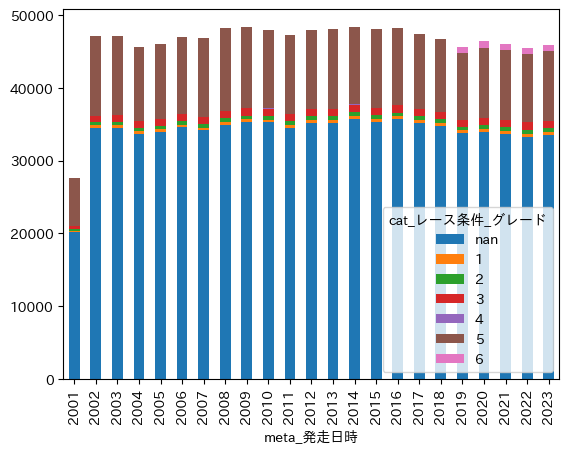

In [8]:
df.groupby(df["meta_発走日時"].dt.year)["cat_レース条件_グレード"].value_counts(
    dropna=False
).unstack().plot(kind="bar", stacked=True)

chi2: 227.94623448192644, p: 2.100388187634774e-46, dof: 6
"Observed Yes" represents the actual counts of the event happening for
each category,     while the "Expected Yes" bars show the counts we
would expect if there was no association     between the two
variables. The size of the "Observed Yes" bars relative to the
"Expected     Yes" bars indicates the strength of the association.


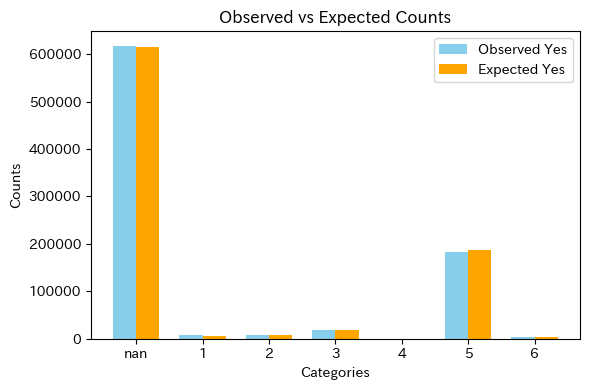

In [13]:
chi2_test(df, "cat_レース条件_グレード", "meta_複勝的中")

In [11]:
imputer = SimpleImputer(strategy="constant", fill_value="N/A")
encoder = OrdinalEncoder(categories=[["1", "2", "3", "4", "5", "6", "N/A"]])
pd.concat(
    [
        df["cat_レース条件_グレード"].rename("original"),
        pd.DataFrame(
            encoder.fit_transform(
                imputer.fit_transform(df[["cat_レース条件_グレード"]])
            ),
            columns=["encoded"],
        ),
    ],
    axis=1,
).value_counts(dropna=False).sort_index()

original  encoded
1         0.0          8555
2         1.0         11042
3         2.0         22205
4         3.0           183
5         4.0        236210
6         5.0          4255
NaN       6.0        781049
Name: count, dtype: int64

## 馬場差 (todo)

**Insights:**
* Nulls only exist up to 2003

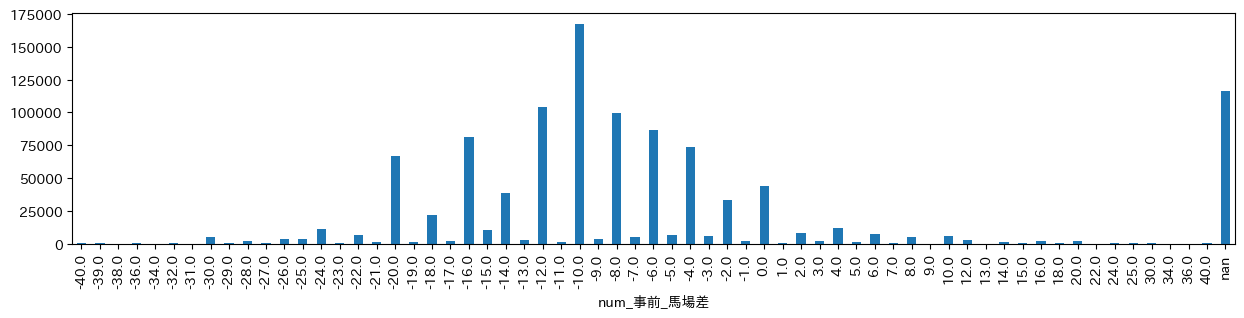

In [29]:
df["num_事前_馬場差"].value_counts(dropna=False).sort_index().plot(
    kind="bar", figsize=(15, 3)
)

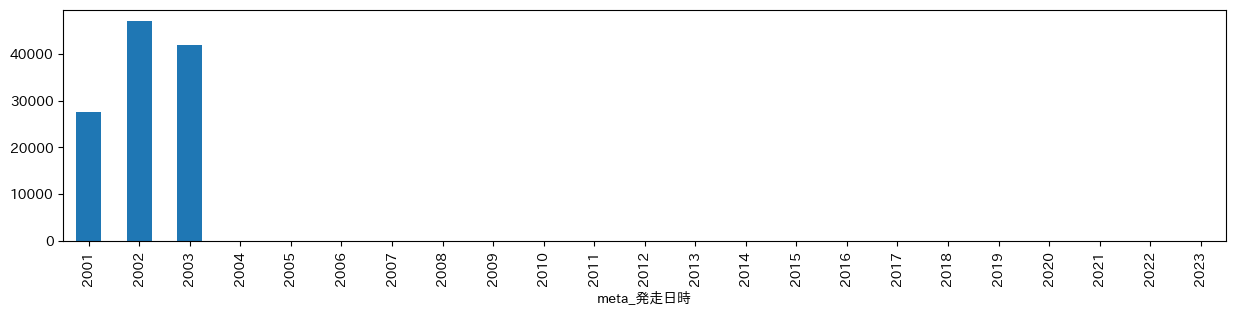

In [59]:
# Get the number of null num_事前_馬場差 over meta_発走日時.dt.year
df["num_事前_馬場差"].isnull().groupby(df["meta_発走日時"].dt.year).sum().plot(
    kind="bar", figsize=(15, 3)
)

In [98]:
# what percent of values are null
df["num_事前_馬場差"].isnull().mean()

0.10947165911768605

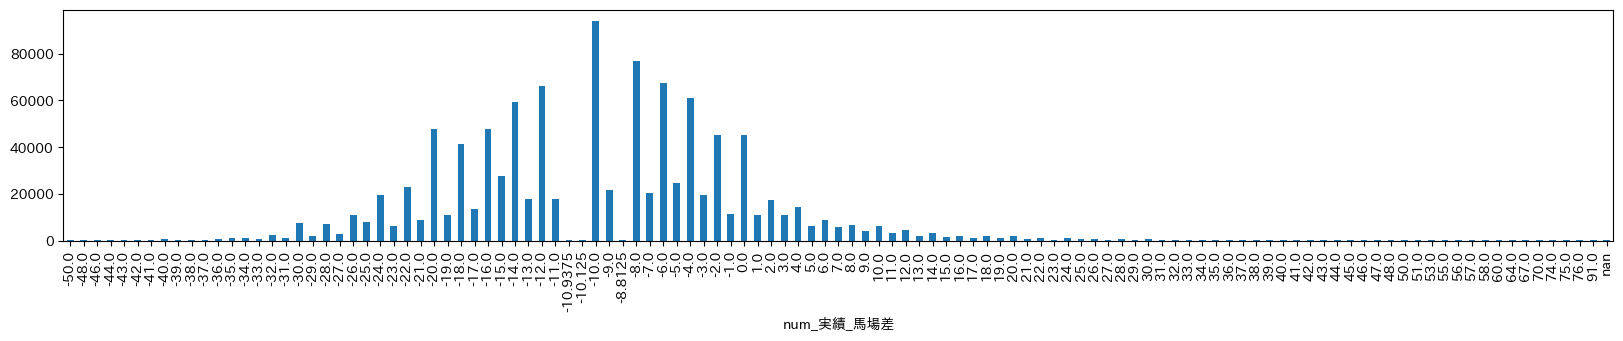

In [31]:
df["num_実績_馬場差"].value_counts(dropna=False).sort_index().plot(
    kind="bar", figsize=(20, 3)
)

In [32]:
df["num_実績_馬場差"].isna().sum()

419

In [97]:
# mean difference between the two columns
df["num_事前_馬場差"].mean() - df["num_実績_馬場差"].mean()

-0.3866431913334196

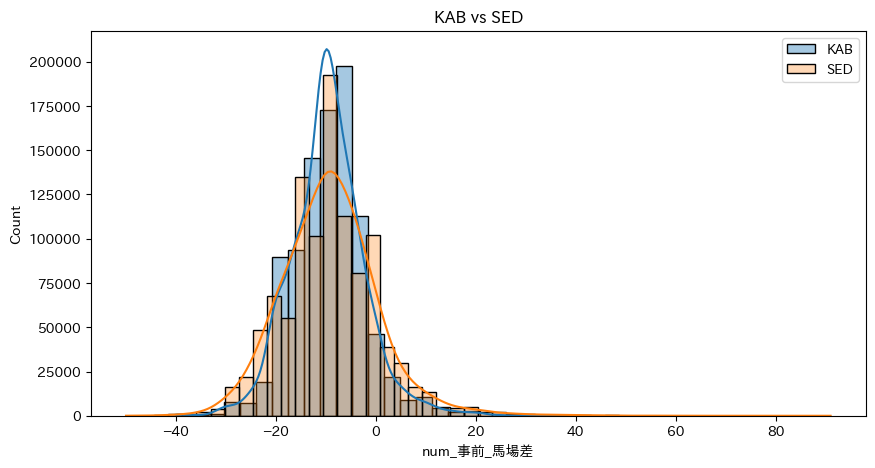

In [96]:
# Create a histogram with superimposed density curve for "num_事前_馬場差", "num_実績_馬場差" with alpha=0.5
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(
    df["num_事前_馬場差"],
    ax=ax,
    label="KAB",
    bins=25,
    alpha=0.4,
    kde=True,
    kde_kws={"bw_adjust": 4},
)
sns.histplot(
    df["num_実績_馬場差"],
    ax=ax,
    label="SED",
    bins=50,
    alpha=0.3,
    kde=True,
    kde_kws={"bw_adjust": 4},
)
ax.set_title("KAB vs SED")
ax.legend()
plt.show()

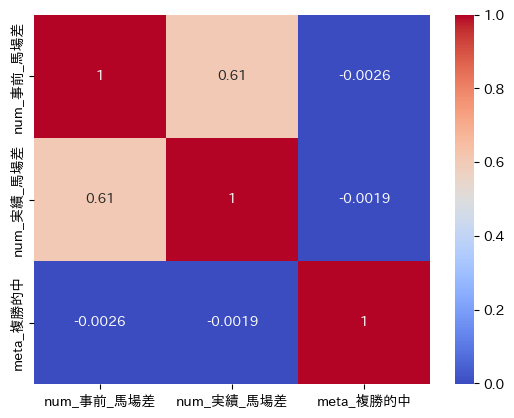

In [5]:
sns.heatmap(
    df[["num_事前_馬場差", "num_実績_馬場差", "meta_複勝的中"]].corr(),
    annot=True,
    cmap="coolwarm",
)

## cat_芝種類

```
1:野芝, 2:洋芝, 3:混生
```

**Insights:**
* Half are nulls
* Nulls mostly when track type is dirt
* Between 1999-2002 there are nulls for 芝 track type too
* Influenced by various factors, most notable トラック種別, 場コード and temperature
* impute TURF with "most frequent" strategy
* impute DIRT with "N/A" placeholder class
* use one-hot encoding

In [5]:
df["cat_芝種類"] = df["cat_芝種類"].astype("category")
df["cat_トラック種別"] = df["cat_トラック種別"].astype("category")
df["cat_芝種類"].value_counts(dropna=False)

cat_芝種類
NaN    564727
3      363952
1       92739
2       42081
Name: count, dtype: int64

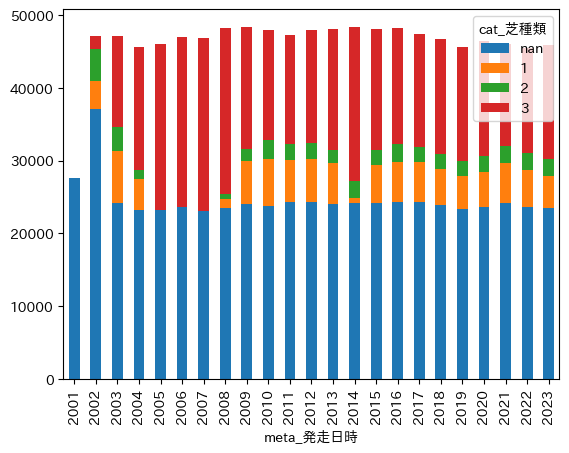

In [9]:
df.groupby(df["meta_発走日時"].dt.year)["cat_芝種類"].value_counts(
    dropna=False
).unstack().plot(kind="bar", stacked=True)

chi2: 112.25618317456528, p: 3.5870968678774616e-24, dof: 3
"Observed Yes" represents the actual counts of the event happening for
each category,     while the "Expected Yes" bars show the counts we
would expect if there was no association     between the two
variables. The size of the "Observed Yes" bars relative to the
"Expected     Yes" bars indicates the strength of the association.


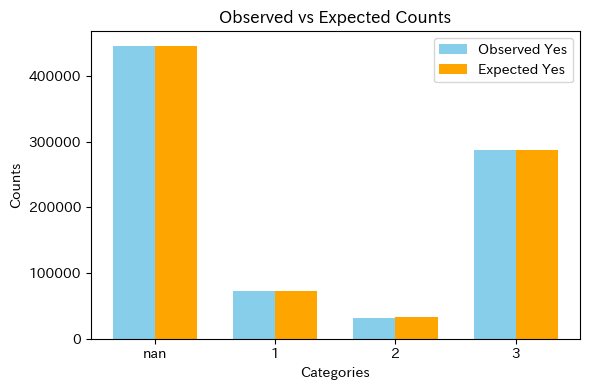

In [12]:
chi2_test(df, "cat_芝種類", "meta_複勝的中")

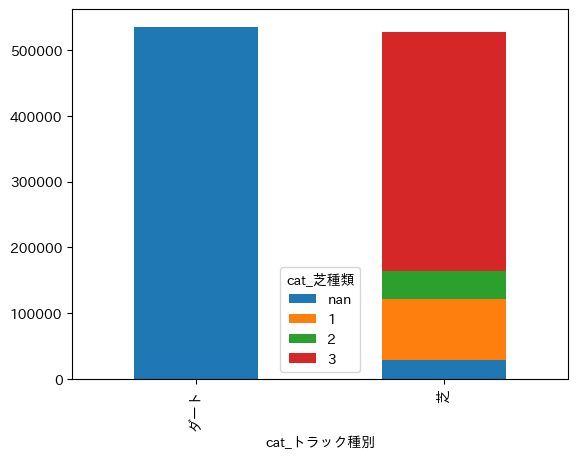

In [27]:
# When is this null?
df[df["meta_発走日時"].dt.year >= 2001].groupby("cat_トラック種別")[
    "cat_芝種類"
].value_counts(dropna=False).unstack().plot(kind="bar", stacked=True)

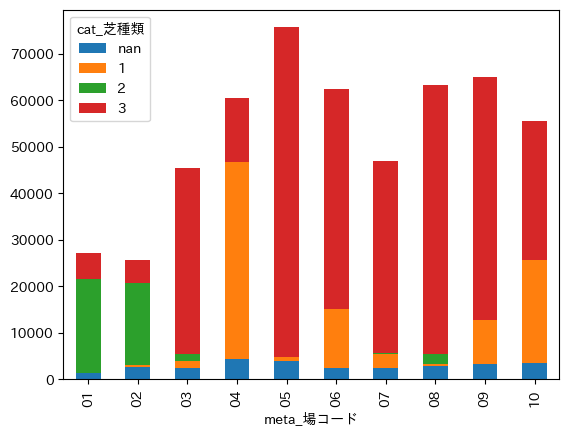

In [7]:
turf_races = df[df["cat_トラック種別"] == "芝"]
turf_races.groupby("meta_場コード")["cat_芝種類"].value_counts(
    dropna=False
).unstack().plot(kind="bar", stacked=True)

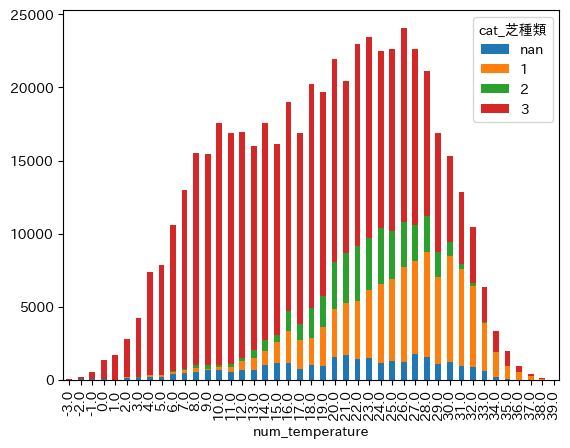

In [10]:
turf_races.groupby(turf_races["num_temperature"].round())["cat_芝種類"].value_counts(
    dropna=False
).unstack().plot(kind="bar", stacked=True)

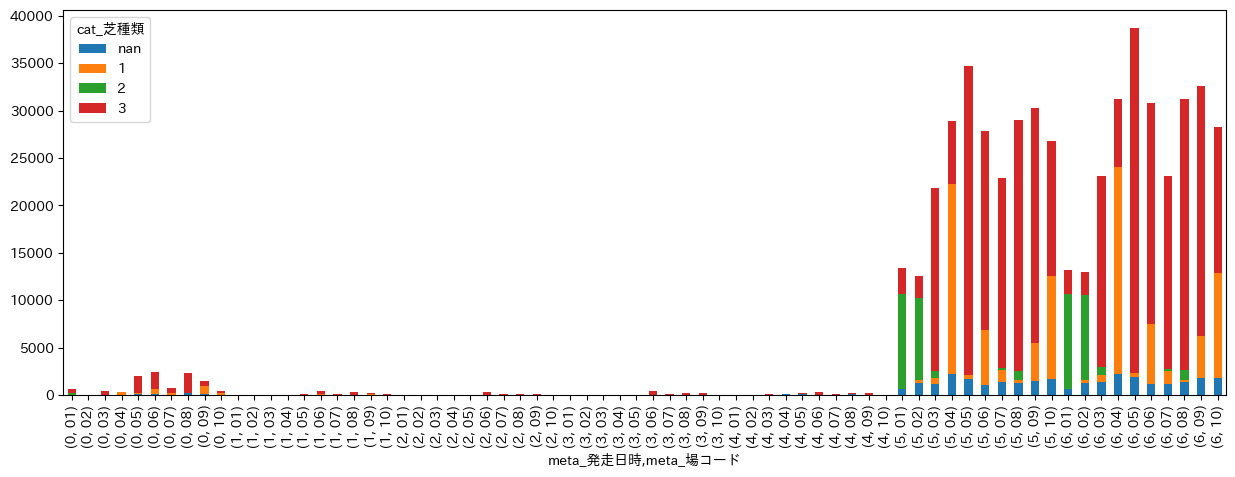

In [13]:
turf_races.groupby(
    [turf_races["meta_発走日時"].dt.day_of_week, turf_races["meta_場コード"]]
)["cat_芝種類"].value_counts(dropna=False).unstack().plot(
    kind="bar", stacked=True, figsize=(15, 5)
)

In [10]:
imputer = SimpleImputer(strategy="most_frequent")

df.loc[df["cat_トラック種別"] == "芝", "cat_芝種類_imputed"] = imputer.fit_transform(
    df.loc[df["cat_トラック種別"] == "芝"][["cat_芝種類"]]
)[:, 0]
df.loc[df["cat_トラック種別"] != "芝", "cat_芝種類_imputed"] = "N/A"

/var/folders/1p/ngsbv_gj3px52qmhqchv10j00000gn/T/ipykernel_25475/905090709.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("cat_トラック種別")["cat_芝種類_imputed"].value_counts(dropna=False).unstack().plot(kind="bar", stacked=True);


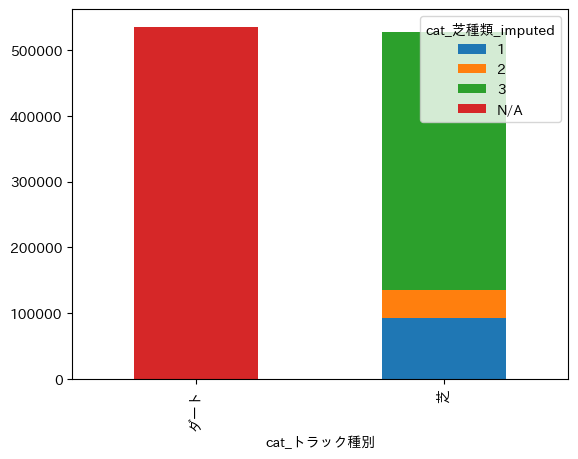

In [11]:
df.groupby("cat_トラック種別")["cat_芝種類_imputed"].value_counts(
    dropna=False
).unstack().plot(kind="bar", stacked=True)

## num_草丈

**Insights:**
* 5% nulls, mostly in 1999-2002, then only very sparse
* Don't use years 1999-2002
* For turf races, impute by doing a forward fill by racetrack
* Ignore feature for dirt races

```python
tmp = df[df["cat_トラック種別"] == "芝"]
tmp["num_草丈_imputed"] = tmp.sort_values("meta_発走日時").groupby("meta_場コード")["num_草丈"].ffill()
```

In [16]:
df["num_草丈"].sample(5)

747969     14.0
140489     14.0
489382     14.0
1173969    14.0
39411      18.0
Name: num_草丈, dtype: float64

In [17]:
df["num_草丈"].describe()

count    1.131010e+06
mean     1.434421e+01
std      1.989064e+00
min      0.000000e+00
25%      1.400000e+01
50%      1.400000e+01
75%      1.600000e+01
max      2.000000e+01
Name: num_草丈, dtype: float64

In [18]:
df["num_草丈"].min(), df["num_草丈"].median(), df["num_草丈"].max()

(0.0, 14.0, 20.0)

<Axes: ylabel='Frequency'>

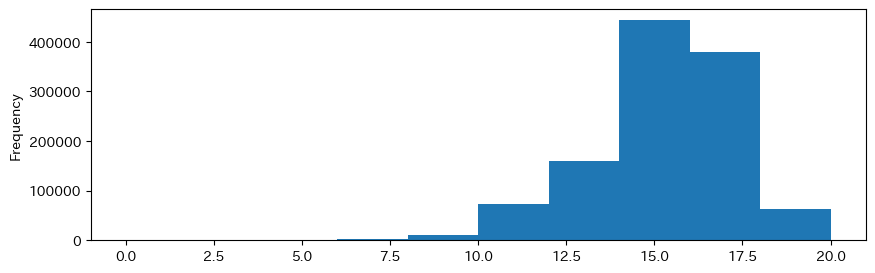

In [19]:
df["num_草丈"].plot(kind="hist", figsize=(10, 3))

In [20]:
df["num_草丈"].value_counts(dropna=False).sort_index() / len(df) * 100

num_草丈
0.0      0.013142
6.0      0.030553
7.0      0.131586
8.0      0.316744
9.0      0.608126
10.0     5.098296
11.0     0.997109
12.0    10.114393
13.0     3.216078
14.0    36.157917
15.0     0.971913
16.0    31.732703
17.0     0.063031
18.0     5.122738
20.0     0.098271
NaN      5.327400
Name: count, dtype: float64

In [21]:
# How many races per year have null num_草丈?
tmp_races = (
    df.groupby("meta_レースキー")["num_草丈"]
    .mean()
    .reset_index()
    .merge(df[["meta_発走日時", "meta_レースキー"]], on="meta_レースキー")
    .drop_duplicates()
)
tmp_races["num_草丈"].isnull().groupby(tmp_races["meta_発走日時"].dt.year).sum()

meta_発走日時
2001    2034
2002    1930
2003       0
2004       0
2005       0
2006       0
2007       0
2008       0
2009      23
2010       0
2011      12
2012      23
2013      15
2014       0
2015       0
2016       0
2017       0
2018       0
2019       0
2020       0
2021       0
2022       0
2023       0
Name: num_草丈, dtype: int64

<Axes: title={'center': 'Number of nulls in cat_草丈'}, xlabel='meta_発走日時'>

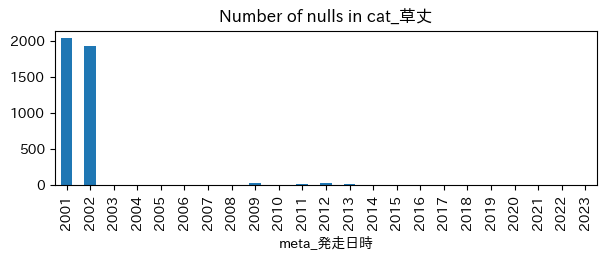

In [22]:
tmp_races["num_草丈"].isnull().groupby(tmp_races["meta_発走日時"].dt.year).sum().plot(
    kind="bar", figsize=(7, 2), title="Number of nulls in cat_草丈"
)

<Axes: title={'center': 'Number of nulls in num_草丈 for 芝'}, xlabel='meta_発走日時'>

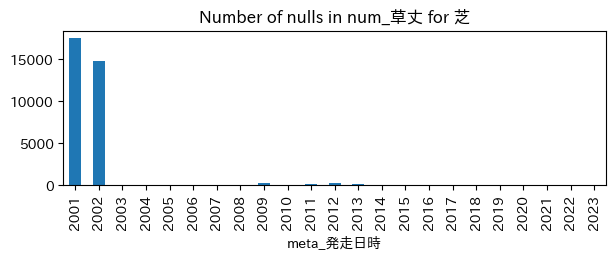

In [23]:
df.loc[df["cat_トラック種別"] == "芝"]["num_草丈"].isnull().groupby(
    df.loc[df["cat_トラック種別"] == "芝"]["meta_発走日時"].dt.year
).sum().plot(kind="bar", figsize=(7, 2), title="Number of nulls in num_草丈 for 芝")

<Axes: title={'center': 'Mean num_草丈 by month'}, xlabel='meta_発走日時'>

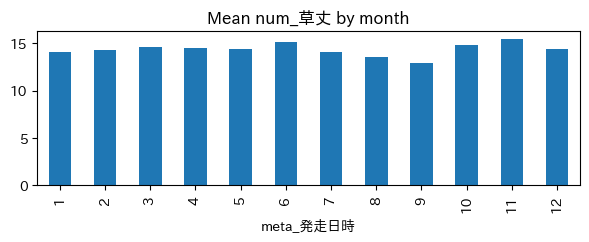

In [25]:
df.groupby(df["meta_発走日時"].dt.month)["num_草丈"].mean().plot(
    kind="bar", figsize=(7, 2), title="Mean num_草丈 by month"
)

In [26]:
# Forward fill num_草丈 by meta_場コード, using meta_発走日時 to guide the forward fill
tmp = df[df["cat_トラック種別"] == "芝"]
tmp["num_草丈_imputed"] = tmp.sort_values("meta_発走日時").groupby("meta_場コード")["num_草丈"].ffill()
tmp = tmp[tmp["meta_発走日時"] >= "2003"]
tmp[tmp["num_草丈"].isnull()][["meta_発走日時", "meta_場コード", "num_草丈", "num_草丈_imputed"]].head()

/var/folders/1p/ngsbv_gj3px52qmhqchv10j00000gn/T/ipykernel_1450/301784234.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["num_草丈_imputed"] = tmp.sort_values("meta_発走日時").groupby("meta_場コード")["num_草丈"].ffill()


,meta_発走日時,meta_場コード,num_草丈,num_草丈_imputed
2155,2009-09-19 07:10:00,04,NaN,13.0
3459,2011-10-10 02:30:00,05,NaN,18.0
3460,2011-10-10 03:50:00,05,NaN,18.0
5104,2012-09-17 03:35:00,06,NaN,12.0
5106,2012-09-17 05:05:00,06,NaN,12.0


In [54]:
tmp[(tmp["meta_発走日時"] >= "2011-10-09 07:00") & (tmp["meta_場コード"] == "05")][
    ["meta_発走日時", "meta_場コード", "num_草丈", "num_草丈_imputed"]
].sort_values(["meta_場コード", "meta_発走日時"]).head(20)

,meta_発走日時,meta_場コード,num_草丈,num_草丈_imputed
163668,2011-10-09 07:20:00,05,18.0,18.0
216793,2011-10-09 07:20:00,05,18.0,18.0
248664,2011-10-09 07:20:00,05,18.0,18.0
301766,2011-10-09 07:20:00,05,18.0,18.0
683192,2011-10-09 07:20:00,05,18.0,18.0
714807,2011-10-09 07:20:00,05,18.0,18.0
735825,2011-10-09 07:20:00,05,18.0,18.0
767411,2011-10-09 07:20:00,05,18.0,18.0
935844,2011-10-09 07:20:00,05,18.0,18.0
967470,2011-10-09 07:20:00,05,18.0,18.0


## num_中間降水量

* There are only 6 dates after 2003 where nulls exist.
* Nulls mostly in 1999-2002
* 414 cm max value in Kogura on 2010-07-17 & 2010-07-18, looks legit (checked visualcrossing)
* Since the number of races with nulls is very low, look up the weather data for these dates and impute the value directly.

In [4]:
df["num_中間降水量"].sample(5)

791925       0.0
404785       0.0
212630      15.0
649343       3.0
1026900    120.5
Name: num_中間降水量, dtype: float64

In [5]:
df["num_中間降水量"].describe()

count    1.130099e+06
mean     1.749175e+01
std      2.850410e+01
min      0.000000e+00
25%      0.000000e+00
50%      7.500000e+00
75%      2.250000e+01
max      4.145000e+02
Name: num_中間降水量, dtype: float64

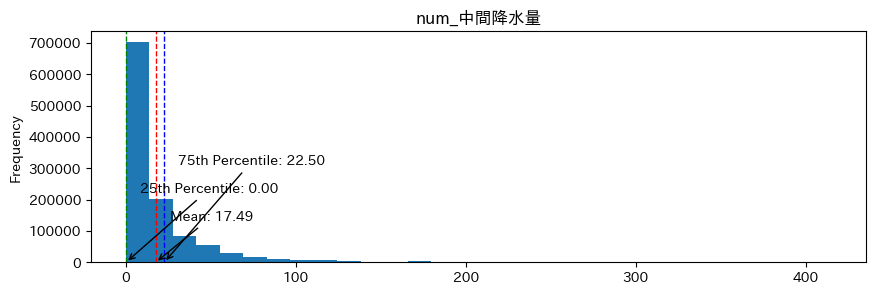

In [66]:
# Calculate the 25th and 75th percentiles
percentile_25 = df["num_中間降水量"].quantile(0.25)
percentile_75 = df["num_中間降水量"].quantile(0.75)

# Plot the histogram
df["num_中間降水量"].plot(kind="hist", figsize=(10, 3), bins=30, title="num_中間降水量")

# Add vertical lines for the percentiles
plt.axvline(df["num_中間降水量"].mean(), color="r", linestyle="dashed", linewidth=1)
plt.axvline(percentile_25, color="g", linestyle="dashed", linewidth=1)
plt.axvline(percentile_75, color="b", linestyle="dashed", linewidth=1)

# Add annotations
plt.annotate(
    f"Mean: {df['num_中間降水量'].mean():.2f}",
    xy=(df["num_中間降水量"].mean(), 0),
    xytext=(10, 30),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", lw=1),
)
plt.annotate(
    f"25th Percentile: {percentile_25:.2f}",
    xy=(percentile_25, 0),
    xytext=(10, 50),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", lw=1),
)
plt.annotate(
    f"75th Percentile: {percentile_75:.2f}",
    xy=(percentile_75, 0),
    xytext=(10, 70),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", lw=1),
)

plt.show()

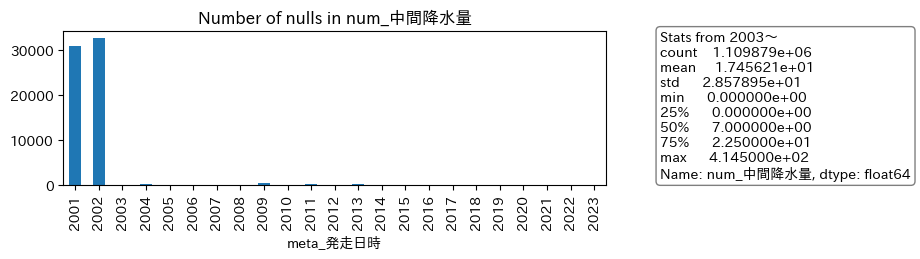

In [82]:
# Plot nulls in num_中間降水量 by year
description = "Stats from 2003〜\n" + str(
    df[df["meta_発走日時"].dt.year >= 2003]["num_中間降水量"].describe()
)
ax = (
    df["num_中間降水量"]
    .isnull()
    .groupby(df["meta_発走日時"].dt.year)
    .sum()
    .plot(kind="bar", figsize=(7, 2), title="Number of nulls in num_中間降水量")
)
ax.text(
    x=1.1,
    y=1.0,
    s=description,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
)
plt.show()

In [7]:
# How many nulls per date after 2003?
null_precip = df[df["num_中間降水量"].isnull()].assign(date=df["meta_発走日時"].dt.date)
null_precip = null_precip[null_precip["meta_発走日時"].dt.year >= 2003]
null_precip[["date", "meta_場コード"]].drop_duplicates().value_counts().sort_index()

date        meta_場コード
2004-01-05  06           1
2009-09-19  04           1
2009-09-20  09           1
2011-10-10  05           1
2013-01-14  06           1
            08           1
Name: count, dtype: int64

In [49]:
# 2004-01-05 中山
# Confirmed 0 precipitation for this date (Visual crossing)
df[
    (
        df["meta_発走日時"].dt.date.between(
            datetime.date(2003, 12, 28), datetime.date(2004, 1, 10)
        )
    )
    & (df["meta_場コード"] == "06")
].sample(10).sort_values("meta_発走日時")[["meta_発走日時", "num_中間降水量"]]

,meta_発走日時,num_中間降水量
515025,2003-12-28 03:35:00,0.0
567983,2003-12-28 04:15:00,0.0
260353,2003-12-28 07:00:00,0.0
323990,2004-01-05 01:50:00,NaN
684298,2004-01-05 03:40:00,NaN
207286,2004-01-05 03:40:00,NaN
831615,2004-01-05 05:15:00,NaN
863246,2004-01-05 07:00:00,NaN
1136447,2004-01-10 00:50:00,0.0
705301,2004-01-10 02:40:00,0.0


In [44]:
# 2009-09-19 新潟
df[
    (
        df["meta_発走日時"].dt.date.between(
            datetime.date(2009, 9, 13), datetime.date(2009, 9, 21)
        )
    )
    & (df["meta_場コード"] == "04")
].sample(10).sort_values("meta_発走日時")[["meta_発走日時", "num_中間降水量"]]

,meta_発走日時,num_中間降水量
1018771,2009-09-13 04:40:00,0.5
892428,2009-09-13 05:15:00,0.5
1018772,2009-09-13 05:15:00,0.5
172934,2009-09-13 05:50:00,0.5
586724,2009-09-13 06:25:00,0.5
934535,2009-09-19 01:00:00,NaN
66370,2009-09-19 02:00:00,NaN
1134096,2009-09-19 02:30:00,NaN
109041,2009-09-19 06:35:00,NaN
966165,2009-09-21 03:50:00,2.0


In [18]:
# 2009-09-20 阪神
df[
    (
        df["meta_発走日時"].dt.date.between(
            datetime.date(2009, 9, 13), datetime.date(2009, 9, 21)
        )
    )
    & (df["meta_場コード"] == "09")
].sample(10).sort_values("meta_発走日時")[["meta_発走日時", "num_中間降水量"]]

,meta_発走日時,num_中間降水量
497994,2009-09-13 06:35:00,0.0
476800,2009-09-13 06:35:00,0.0
497995,2009-09-13 07:40:00,0.0
1004347,2009-09-20 01:15:00,NaN
275272,2009-09-20 01:45:00,NaN
317624,2009-09-20 04:15:00,NaN
94333,2009-09-21 01:15:00,13.0
793791,2009-09-21 03:40:00,13.0
83717,2009-09-21 04:50:00,13.0
137095,2009-09-21 07:40:00,13.0


In [21]:
# 2011-10-10  東京 (05)
df[
    (
        df["meta_発走日時"].dt.date.between(
            datetime.date(2011, 9, 27), datetime.date(2011, 10, 15)
        )
    )
    & (df["meta_場コード"] == "05")
].sample(10).sort_values("meta_発走日時")[["meta_発走日時", "num_中間降水量"]]

,meta_発走日時,num_中間降水量
587994,2011-10-08 03:35:00,76.5
956931,2011-10-09 01:15:00,76.5
46383,2011-10-09 04:35:00,76.5
925306,2011-10-09 06:45:00,76.5
1072560,2011-10-10 03:20:00,NaN
418337,2011-10-10 06:00:00,NaN
904308,2011-10-15 01:40:00,0.5
152952,2011-10-15 06:10:00,0.5
1062110,2011-10-15 06:45:00,0.5
248669,2011-10-15 07:20:00,0.5


In [26]:
# 2013-01-14 中山
# Confirmed amout of rain was 17mm for these two races (Visual crossing)
df[
    (
        df["meta_発走日時"].dt.date.between(
            datetime.date(2013, 1, 13), datetime.date(2013, 1, 19)
        )
    )
    & (df["meta_場コード"] == "06")
].sample(10).sort_values("meta_発走日時")[["meta_発走日時", "meta_レースキー", "num_中間降水量"]]

,meta_発走日時,meta_レースキー,num_中間降水量
388262,2013-01-13 01:00:00,06131401,0.0
314038,2013-01-13 04:20:00,06131407,0.0
1157967,2013-01-13 06:35:00,06131411,0.0
409456,2013-01-14 02:00:00,06131503,NaN
377660,2013-01-14 02:00:00,06131503,NaN
800641,2013-01-19 02:30:00,06131604,55.5
653211,2013-01-19 02:30:00,06131604,55.5
1157971,2013-01-19 04:20:00,06131607,55.5
1126594,2013-01-19 04:20:00,06131607,55.5
154647,2013-01-19 04:50:00,06131608,55.5


In [24]:
df["meta_発走日時"].dt.time.value_counts().sort_index()

meta_発走日時
00:30:00       66
00:35:00      126
00:40:00      160
00:50:00    21168
00:55:00    16940
01:00:00    21111
01:01:00       19
01:05:00    14266
01:10:00    17767
01:15:00    12042
01:20:00    20806
01:25:00    16769
01:30:00    24114
01:35:00    10325
01:40:00    22262
01:45:00    12274
01:50:00    23404
01:55:00    16612
02:00:00    20838
02:05:00    11731
02:10:00    21244
02:15:00    11466
02:20:00    16321
02:25:00    14035
02:30:00    14010
02:35:00     9761
02:40:00    13150
02:45:00     6115
02:50:00     7074
02:55:00     3570
03:00:00     2531
03:01:00       74
03:05:00     3920
03:10:00    11521
03:15:00    10645
03:20:00    17199
03:25:00     9605
03:30:00    20324
03:35:00    10572
03:40:00    17177
03:45:00    17666
03:50:00    22388
03:55:00    14378
04:00:00    19133
04:01:00       11
04:05:00    13079
04:10:00    14362
04:15:00    20442
04:20:00    20185
04:25:00    17017
04:30:00    17670
04:31:00       12
04:35:00    11042
04:40:00    15911
04:45:00    13337


In [74]:
# Filter the dataframe
filtered_df = df[df["meta_場コード"] == "10"].sort_values("meta_発走日時")

# Create a Bokeh figure
p = figure(
    title="Mean num_中間降水量",
    x_axis_label="Date",
    y_axis_label="Mean num_中間降水量",
    x_axis_type="datetime",
    min_width=1200,
)

# Plot the data
line = p.line(
    x=filtered_df["meta_発走日時"],
    y=filtered_df["num_中間降水量"],
    line_width=2,
    legend_label="Mean num_中間降水量",
)

# Add a HoverTool to show the value and date on mouseover
hover = HoverTool(renderers=[line], tooltips=[("Date", "@x{%F}"), ("Value", "@y")], formatters={"@x": "datetime"})
p.add_tools(hover)

# Format the x-axis tick labels
p.xaxis.formatter = DatetimeTickFormatter(days="%Y-%m-%d")

# Add a legend
p.legend.location = "top_left"
p.legend.click_policy = "hide"

# Show the plot
show(p)

It appear kogura did have a lot of rain just before the 2010-07-17 & 2010-07-18 races.

![kogura_precip_2010.png](/Users/hankehly/Projects/JapanHorseRaceAnalytics/images/kogura_precip_2010.png)

# Todo

In [ ]:
pd.concat([df.isna().sum().rename("df"), data.isna().sum().rename("data")], axis=1)

,df,data
meta_レースキー,0,0
meta_馬番,0,0
meta_着順,0,0
meta_本賞金,343,343
meta_単勝的中,0,0
meta_単勝払戻金,0,0
meta_複勝的中,0,0
meta_複勝払戻金,0,0
meta_int_races_レースキー,0,0
meta_発走日時,0,0
